## Linear Regression Data Model Optimization 

In [73]:
# Import all dependencies
import pandas as pd
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, text

# Preprocessing 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

# Exploratory Data Analysis (EDA)
import seaborn as sns
import matplotlib.pyplot as plt

# Model Selection
from sklearn.linear_model import LinearRegression

# Stats
import statsmodels.api as sm

# Model Evaluation Metrics 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score


## Load and Visualize the Spotify Data

In [74]:
# Create Database Connection
engine = create_engine("sqlite:///Resources/spotify_2023.sqlite", echo=False)

Removed %ls code

In [75]:
# Reflect Database into ORM Classes
Base = automap_base()
Base.prepare(autoload_with=engine, reflect=True)
MyTable = Base.classes.keys()

session = Session(engine)

C:\Users\baby4\AppData\Local\Temp\ipykernel_1316\2372956060.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(autoload_with=engine, reflect=True)


In [76]:
# Create pandas df after loading the data from the SQLAlchemy engine
clean_spotify_df = pd.read_sql_table('cleaned_spotify_2023', engine)

col_list = []
for col in clean_spotify_df.columns:
    col_list.append(str(col))
clean_spotify_df.columns=col_list

# Rename columns for context
cleaned_spotify_df = clean_spotify_df.rename(columns={'artist(s)_name': 'artists_name',
                        'danceability_%': 'danceability',
                        'valence_%': 'valence',
                        'energy_%': 'energy', 
                        'acousticness_%': 'acousticness', 
                        'instrumentalness_%': 'instrumentalness',  
                        'liveness_%': 'liveness',
                        'speechiness_%': 'speechiness'
                        })

# Verify the change
print(cleaned_spotify_df.columns)

Index(['ID', 'track_name', 'artists_name', 'contributing_artist_count',
       'released_year', 'released_month', 'in_spotify_playlists',
       'spotify_chart_rank', 'streams', 'in_apple_playlists',
       'apple_chart_rank', 'in_deezer_playlists', 'deezer_chart_rank',
       'shazam_chart_rank', 'bpm', 'key', 'mode', 'danceability', 'valence',
       'energy', 'acousticness', 'instrumentalness', 'liveness',
       'speechiness'],
      dtype='object')


In [77]:
# Print udpated df
cleaned_spotify_df.head()

,ID,track_name,artists_name,contributing_artist_count,released_year,released_month,in_spotify_playlists,spotify_chart_rank,streams,in_apple_playlists,...,bpm,key,mode,danceability,valence,energy,acousticness,instrumentalness,liveness,speechiness
0,1,seven feat latto explicit ver,latto jung kook,2,2023,7,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,2,lala,myke towers,1,2023,3,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,3,vampire,olivia rodrigo,1,2023,6,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,4,cruel summer,taylor swift,1,2019,8,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,5,where she goes,bad bunny,1,2023,5,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


In [78]:
# # Drop irrelevant columns 
# new_df = cleaned_spotify_df.drop(columns=['ID', 'track_name', 'artists_name', 'key', 'mode'])
# new_df.head()

In [79]:
# Drop all columns but target (streams) and 'in_spotify_playlists','in_apple_playlists', and 'in_deezer_playlists'
new_df = cleaned_spotify_df.drop(columns=['ID', 'track_name', 'artists_name', 'contributing_artist_count',
       'released_year', 'released_month',  'bpm', 'key', 'mode', 'danceability', 'valence',
       'energy', 'acousticness', 'instrumentalness', 'liveness', 'spotify_chart_rank','apple_chart_rank', 'deezer_chart_rank','shazam_chart_rank',   
       'speechiness'])
new_df.head()

,in_spotify_playlists,streams,in_apple_playlists,in_deezer_playlists
0,553,141381703,43,45
1,1474,133716286,48,58
2,1397,140003974,94,91
3,7858,800840817,116,125
4,3133,303236322,84,87


## Remove outliers

In [80]:
# Calculate quartiles and IQR
quartiles = np.quantile(new_df['streams'], [.25, .75])
iqr = quartiles[1] - quartiles[0]

# Determine the lower and upper bounds
lower_bound = quartiles[0] - (1.5 * iqr)
upper_bound = quartiles[1] + (1.5 * iqr)

# Identify potential outliers
potential_outliers = new_df[(new_df['streams'] < lower_bound) | (new_df['streams'] > upper_bound)]

# Remove outliers from the original DataFrame
cleaned_df = new_df[(new_df['streams'] >= lower_bound) & (new_df['streams'] <= upper_bound)]

# Display the cleaned DataFrame
cleaned_df.head()

,in_spotify_playlists,streams,in_apple_playlists,in_deezer_playlists
0,553,141381703,43,45
1,1474,133716286,48,58
2,1397,140003974,94,91
3,7858,800840817,116,125
4,3133,303236322,84,87


In [81]:
# Updated df info
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750 entries, 0 to 816
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   in_spotify_playlists  750 non-null    int64
 1   streams               750 non-null    int64
 2   in_apple_playlists    750 non-null    int64
 3   in_deezer_playlists   750 non-null    int64
dtypes: int64(4)
memory usage: 29.3 KB


## Exploratory Data Analysis (EDA)

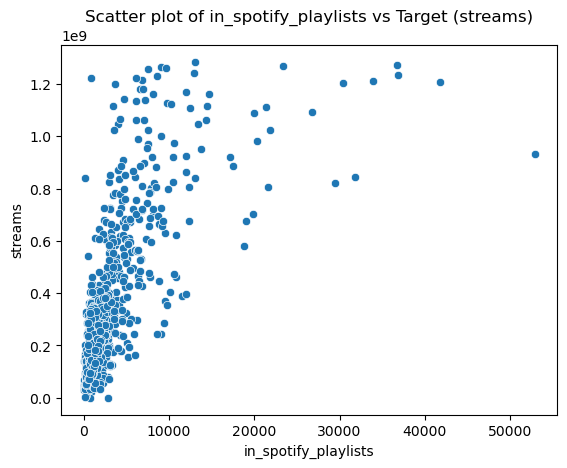

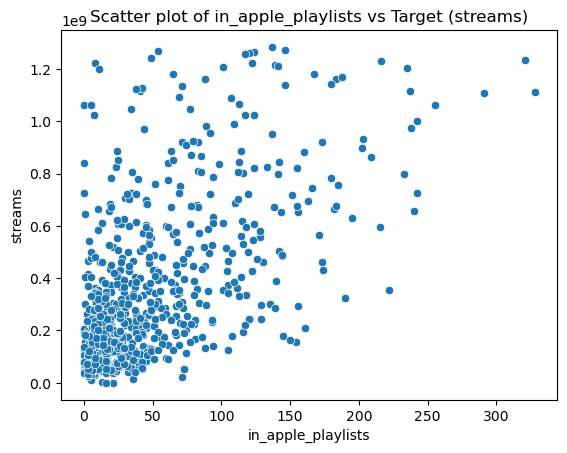

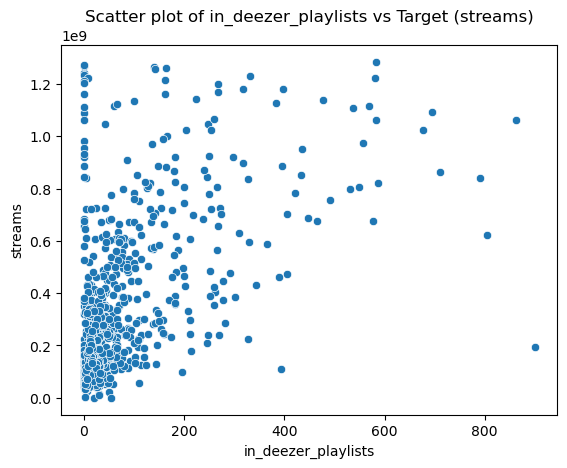

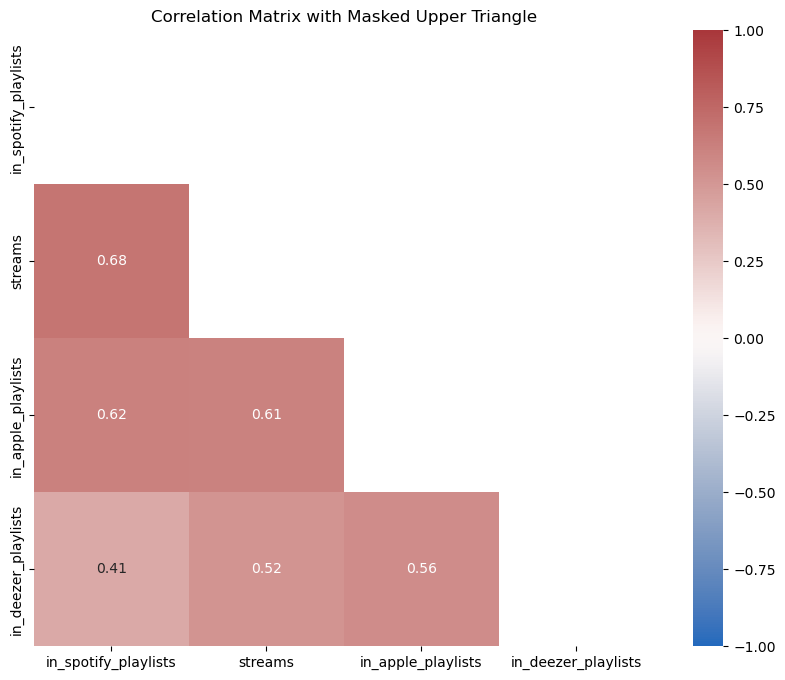

In [82]:
# Specify the target column
target_column = 'streams'

# Visualize relationships between target_column and features via scatter plots
for col in cleaned_df.columns:  # Loop through all columns
    if col != target_column:  # Skip the target column
        sns.scatterplot(x=cleaned_df[col], y=cleaned_df[target_column])  # Use 'streams' as the target column
        plt.title(f'Scatter plot of {col} vs Target ({target_column})')
        plt.xlabel(col)
        plt.ylabel(target_column)
        plt.show()

# Create correlation matrix
matrix = cleaned_df.corr().round(2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(matrix, annot=True, mask=mask, vmin=-1, vmax=1, center=0, cmap='vlag')

# Add title
plt.title('Correlation Matrix with Masked Upper Triangle')

# Show plot
plt.show()


In [83]:
# Display correlation matrix
matrix

,in_spotify_playlists,streams,in_apple_playlists,in_deezer_playlists
in_spotify_playlists,1.00,0.68,0.62,0.41
streams,0.68,1.00,0.61,0.52
in_apple_playlists,0.62,0.61,1.00,0.56
in_deezer_playlists,0.41,0.52,0.56,1.00


Removed 
matrix = new_df.corr()
matrix = matrix.unstack()
matrix[matrix>0]
as the display above lists this information

## Prepare the Data to Fit the Linear Regression Model

In [84]:
# Define your feature set and target variable
X = cleaned_df.drop(columns=['streams'])  # All columns except the target
y = cleaned_df['streams']  # Target column

# Add constant to features for intercept
X = sm.add_constant(X)

# Fit initial Linear Regression model.
initial_model = sm.OLS(y, X).fit()
print(initial_model.summary())


                            OLS Regression Results                            
Dep. Variable:                streams   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     307.4
Date:                Wed, 16 Oct 2024   Prob (F-statistic):          7.10e-130
Time:                        20:41:34   Log-Likelihood:                -15399.
No. Observations:                 750   AIC:                         3.081e+04
Df Residuals:                     746   BIC:                         3.083e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.573e+08 

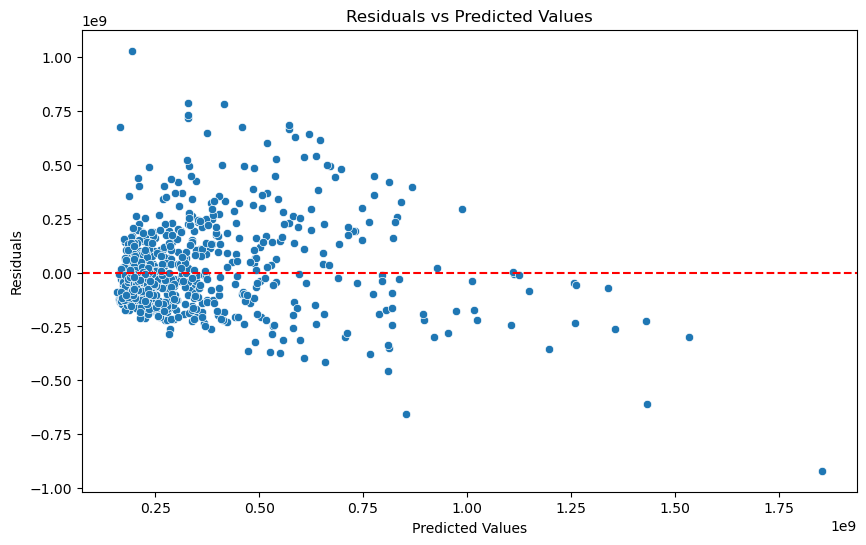

In [85]:
# Test for Linearity
residuals = y - initial_model.predict(X)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=initial_model.predict(X), y=residuals)
plt.axhline(0, color='red', ls='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


## Preprocessing of the Spotify df

In [86]:
# Scale the features data 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  


In [87]:
# Train-Test Split 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

## Initialize and fit linear regression model to make predictions

In [88]:
# Initialize Linear Regression model
linear_model = LinearRegression()

# Fit the model on the training data
linear_model.fit(X_train, y_train)


LinearRegression()

In [89]:
# Final Model

print("Coefficients:", linear_model.coef_)
print("Model's y-intercetp:", linear_model.intercept_)

Coefficients: [0.00000000e+00 1.29273830e+08 6.35312776e+07 6.29001928e+07]
Model's y-intercetp: 338822930.1014171


In [90]:
# Display the model's best fit line formula
coefficients = " + ".join([f"{coef:.4f} * X{i+1}" for i, coef in enumerate(linear_model.coef_) if coef != 0])
print(f"Model's formula: y = {linear_model.intercept_:.4f} + {coefficients}")


Model's formula: y = 338822930.1014 + 129273829.7432 * X2 + 63531277.5520 * X3 + 62900192.8392 * X4


In [91]:
# Display the formula to predict the streaming for a person in 7 years
# Assuming model.coef_ contains multiple coefficients and you want to represent them all
coefficients = " + ".join([f"{coef:.4f} * X{i+1}" for i, coef in enumerate(linear_model.coef_)])
print(f"Model's formula: y = {linear_model.intercept_:.4f} + {coefficients}")

# Predict the streams for an artist in 7 years 
y_7 = linear_model.intercept_ + sum(coef * (7 if i == 0 else 1) for i, coef in enumerate(linear_model.coef_))

# Display the prediction
print(f"Predicted streams of an artist in 7 years: {y_7:.2f}")


Model's formula: y = 338822930.1014 + 0.0000 * X1 + 129273829.7432 * X2 + 63531277.5520 * X3 + 62900192.8392 * X4
Predicted streams of an artist in 7 years: 594528230.24


In [92]:
# Make predictions using the X set
predicted_y_values = linear_model.predict(X)

c:\Users\baby4\anaconda30\envs\dev\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [93]:
# Create a copy of the original cleaned streaming data
df_streamed_predicted = cleaned_df.copy()

# Add a column with the predicted streaming values
df_streamed_predicted["streams_predicted"] = predicted_y_values

# Display sample data
df_streamed_predicted.head()


,in_spotify_playlists,streams,in_apple_playlists,in_deezer_playlists,streams_predicted
0,553,141381703,43,45,7.738960e+10
1,1474,133716286,48,58,1.975862e+11
2,1397,140003974,94,91,1.926302e+11
3,7858,800840817,116,125,1.031405e+12
4,3133,303236322,84,87,4.161627e+11


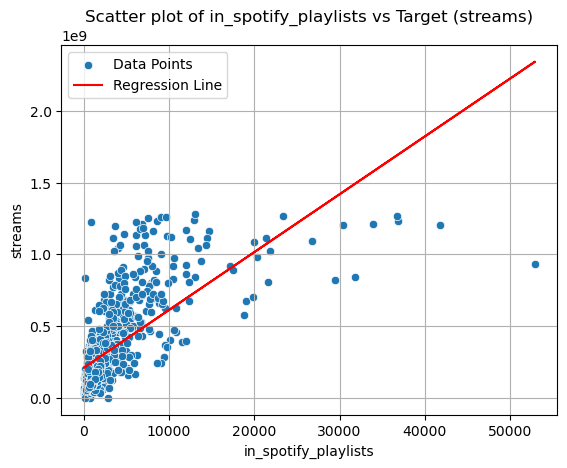

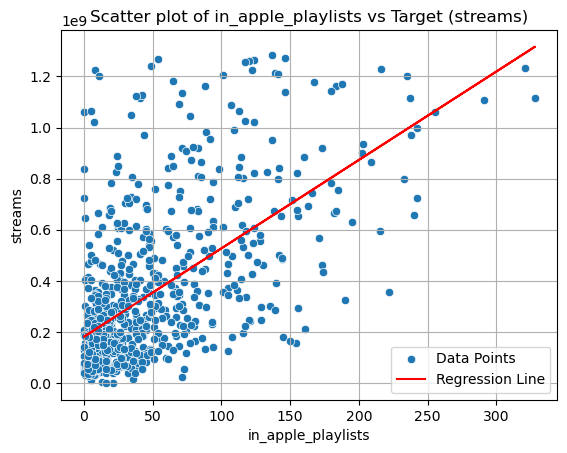

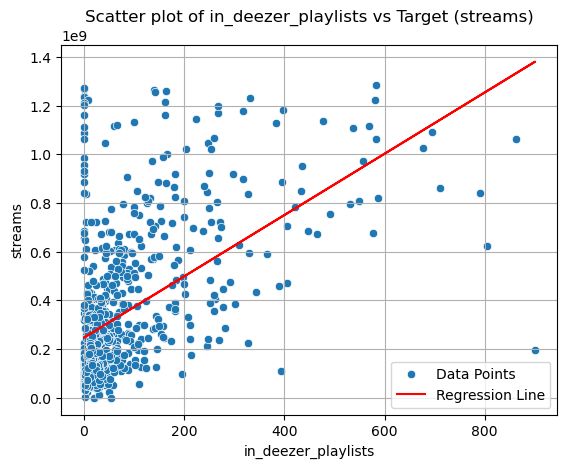

In [94]:
# Loop through all columns in the df_streamed_predicted df to show your predicted values
for col in df_streamed_predicted.columns:  
    if col != target_column and col != "streams_predicted":  # Skip the target column and the predicted column
        # Create scatter plot
        sns.scatterplot(x=df_streamed_predicted[col], y=df_streamed_predicted[target_column], label='Data Points')
        
        # Fit a linear regression model for the current feature
        X = df_streamed_predicted[[col]]  # Reshape for a single feature
        y = df_streamed_predicted[target_column]
        model = LinearRegression()
        model.fit(X, y)
        
        # Generate predicted values based on the feature
        predicted_y = model.predict(X)
        
        # Overlay the linear regression line
        plt.plot(df_streamed_predicted[col], predicted_y, color='red', label='Regression Line')

        # Set plot titles and labels
        plt.title(f'Scatter plot of {col} vs Target ({target_column})')
        plt.xlabel(col)
        plt.ylabel(target_column)
        plt.legend()
        plt.grid()
        plt.show()



## Evaluate the model's performance

In [95]:
# Final Model's performance 
y_pred = linear_model.predict(X_test)

# Cross Validate
linear_cv_scores = cross_val_score(linear_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Linear Regression Cross-validated MSE:", -linear_cv_scores.mean())

# Print Model's performance: MSE & R2
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model's performance MSE: {mse}")
print(f"Model's performance R-squared: {r2}")


Linear Regression Cross-validated MSE: 3.9553420744286536e+16
Model's performance MSE: 4.561357820906939e+16
Model's performance R-squared: 0.5544391092241188
